In [78]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from keras import backend as K
from keras import layers
from keras.utils.np_utils import to_categorical   
from keras import models, optimizers
from keras import metrics
from keras.datasets import cifar10

In [12]:
original_img_size = (32, 32, 3)

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [14]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [29]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [30]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [31]:
nbatch = 100
latent_size = 5

In [41]:
pic_input = layers.Input(batch_shape=(nbatch,) + x_train.shape[1:])
ans_input = layers.Input(batch_shape=(nbatch,) + y_train.shape[1:])

#init
#encoder
conv_en_1 = layers.Conv2D(3, kernel_size=(2, 2), padding='same', activation='relu')
conv_en_2 = layers.Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu', strides=(2, 2))
conv_en_3 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')
conv_en_4 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')
flat_en = layers.Flatten()
dense_en = layers.Dense(512, activation='relu')
mu_layout = layers.Dense(latent_size, activation='linear')
log_sigma_layout = layers.Dense(latent_size, activation='linear')

def eval_z(z_params):
    mu, log_sigma = z_params
    eps = K.random_normal_variable((nbatch, latent_size), mean=0, scale=1)
    z = mu + K.exp(log_sigma / 2) * eps
    return z

z_layout = layers.Lambda(eval_z)

#decoder
dense_dec_1 = layers.Dense(512, activation='relu')
dense_dec_2 = layers.Dense(int(x_train.shape[1]/2*x_train.shape[2]/2*x_train.shape[3]), activation='relu')
reshape_dec = layers.Reshape((int(x_train.shape[1]/2), int(x_train.shape[2]/2), x_train.shape[3]))
deconv_dec_1 = layers.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu')
deconv_dec_2 = layers.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu')
deconv_dec_3 = layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu')
deconv_out = layers.Conv2D(3, kernel_size=(2, 2), padding='valid', activation='sigmoid')

#net
conv_en_out_1 = conv_en_1(pic_input)
conv_en_out_2 = conv_en_2(conv_en_out_1)
conv_en_out_3 = conv_en_3(conv_en_out_2)
conv_en_out_4 = conv_en_4(conv_en_out_3)
flat_pic = flat_en(conv_en_out_4)
flat_input = layers.concatenate([flat_pic, ans_input], axis=1)
dense_en_out = dense_en(flat_input)
mu = mu_layout(dense_en_out)
log_sigma = log_sigma_layout(dense_en_out)

z = z_layout([mu, log_sigma])
z_cond = layers.concatenate([z, ans_input], axis=1)

dense_dec_out_1 = dense_dec_1(z_cond)
dense_dec_out_2 = dense_dec_2(dense_dec_out_1)
reshape_dec_out = reshape_dec(dense_dec_out_2)
deconv_dec_out_1 = deconv_dec_1(reshape_dec_out)
deconv_dec_out_2 = deconv_dec_2(deconv_dec_out_1)
deconv_dec_out_3 = deconv_dec_3(deconv_dec_out_2)
out = deconv_out(deconv_dec_out_3)

In [95]:
#encoder
en_pic_input = layers.Input(batch_shape=(nbatch,) + x_train.shape[1:])
en_ans_input = layers.Input(batch_shape=(nbatch,) + y_train.shape[1:])

en_conv_en_out_1 = conv_en_1(en_pic_input)
en_conv_en_out_2 = conv_en_2(en_conv_en_out_1)
en_conv_en_out_3 = conv_en_3(en_conv_en_out_2)
en_conv_en_out_4 = conv_en_4(en_conv_en_out_3)
en_flat_pic = flat_en(en_conv_en_out_4)
en_flat_input = layers.concatenate([en_flat_pic, en_ans_input], axis=1)
en_dense_en_out = dense_en(en_flat_input)
en_mu = mu_layout(en_dense_en_out)
en_log_sigma = log_sigma_layout(en_dense_en_out)
en_z = z_layout([en_mu, en_log_sigma])

In [92]:
#decoder
d_ans_input = layers.Input(shape=(y_test.shape[1],))
d_z = layers.Input(shape=(latent_size,))
d_inputs = layers.concatenate([d_z, d_ans_input], axis=1)

d_dense_dec_out_1 = dense_dec_1(d_inputs)
d_dense_dec_out_2 = dense_dec_2(d_dense_dec_out_1)
d_reshape_dec_out = reshape_dec(d_dense_dec_out_2)
d_deconv_dec_out_1 = deconv_dec_1(d_reshape_dec_out)
d_deconv_dec_out_2 = deconv_dec_2(d_deconv_dec_out_1)
d_deconv_dec_out_3 = deconv_dec_3(d_deconv_dec_out_2)
d_out = deconv_out(d_deconv_dec_out_3)

In [111]:
#loss
def vae_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    xent_loss = metrics.binary_crossentropy(y_true, y_pred)
    kl_loss = - 0.5 * K.mean(1 + log_sigma - K.square(mu) - K.exp(log_sigma), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [112]:
cvae = models.Model([pic_input, ans_input], out)
encoder = models.Model([en_pic_input, en_ans_input], en_z)
decoder = models.Model([d_z, d_ans_input], d_out)

In [113]:
cvae.compile(optimizer="adam", loss=vae_loss)

cvae.fit([x_train, y_train], x_train, batch_size=nbatch, epochs=20, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 227s - loss: 0.6806 - val_loss: 0.6806
Epoch 2/20
45000/45000 [==============================] - 223s - loss: 0.6806 - val_loss: 0.6806
Epoch 3/20
45000/45000 [==============================] - 221s - loss: 0.6806 - val_loss: 0.6806
Epoch 4/20
45000/45000 [==============================] - 223s - loss: 0.6806 - val_loss: 0.6805
Epoch 5/20
45000/45000 [==============================] - 223s - loss: 0.6806 - val_loss: 0.6806
Epoch 6/20
45000/45000 [==============================] - 220s - loss: 0.6806 - val_loss: 0.6806
Epoch 7/20
45000/45000 [==============================] - 221s - loss: 0.6806 - val_loss: 0.6806
Epoch 8/20
45000/45000 [==============================] - 222s - loss: 0.6806 - val_loss: 0.6805
Epoch 9/20
45000/45000 [==============================] - 223s - loss: 0.6806 - val_loss: 0.6806
Epoch 10/20
45000/45000 [==============================] - 223s - loss: 0.6806

Training history


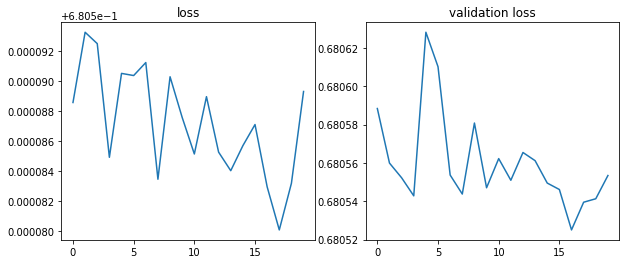

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Training history")
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(cvae.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(cvae.history.history['val_loss'])
ax2.set_title('validation loss')

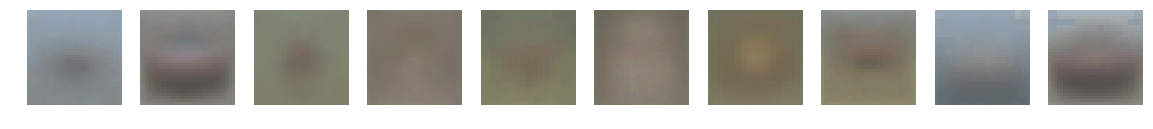

In [117]:
from keras.utils import np_utils
pic_size = 32

z_sample = np.random.rand(1, 5) # random 

plt.figure(figsize=(20, 2))
for i in range(10):
    c = np_utils.to_categorical(i, y_train.shape[1])
    x_decoded = decoder.predict([z_sample, c])
    digit = x_decoded[0].reshape(pic_size, pic_size, 3)

    plt.subplot(1, y_train.shape[1], i + 1)
    plt.axis('off')
    plt.imshow(digit)
plt.show()